# Imports

In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import math 

import os
import sys
import struct
import time
import pandas as pd

import pandas as pd
import seaborn as sns
import h5py
import tqdm as notebook_tqdm

from tqdm import tqdm


%matplotlib inline

In [2]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"
BETAS_PATH = NSD_ROOT+"/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/"


DEVICE = 'cpu'

# Load the `K`, `betas` and `S_mat` matrices for correlation 

The files (for the betas) contain data for upto 37 sessions only (out of 40 sessions as listed in the paper) 

Thus the shape of the concatenated beta file (consisting of a multiple of 750 trials) is 27,750 instead of 30,000 (for 40 sessions) 

We can deduce that: 

```
27750 - 30000 = 2250 

2250 / 750 = 3 

37 + 3 = 40 sessions
```

Thus we need to remove those last 3 sessions from the `S_mat` matrix which contains the Saliency maps for all 40 sesions and reduce it for 37 sessions

In [3]:
# Load helper functions
%run ../src/helper_fuctions.py
%load_ext autoreload
%autoreload 2 

In [4]:
S_mat_full_subj1 = np.load(DATA_PATH+"/S_mat_full_batched.npy")
print(S_mat_full_subj1.shape) # is actually # 30,000 x 425 x 425. Has one extra row 
S_mat = S_mat_full_subj1.reshape(-1,180625)
S_mat = S_mat[1:,:] # (30000, 180625)
S_mat = S_mat[:27750,:] # remove the last 3 session voxels for session 38,39 and 40 
print(S_mat.shape)

(30001, 425, 425)
(27750, 180625)


In [5]:
def gen_corr_w_beta(roi, print_log, S_mat = S_mat):
    
    print(f"Computing correlation for {roi}\n")

    K_mat = np.load(DATA_PATH+f"/K_mat_subj1_{roi}.npy.npz")
    K_mat = K_mat['arr_0']
   
    if print_log: 
        print(f"K matrix: {K_mat.shape}")
    
    betas_mat = np.load(DATA_PATH+f"/betas_full_{roi}.npy")
          
    roi_valid_indices = np.load(DATA_PATH+f"/{roi}_valid_indices_subj1.npy")
   
    if print_log: 
        print(f"Betas matrix before valid: {betas_mat.shape}")
        print(f"Valid indices shape: {roi_valid_indices.shape}")
    
    # index the betas for the corresponding voxels that are valid 
    betas_val = betas_mat[:,roi_valid_indices] 
    betas_val = betas_val[1:,:] # remove the first dummy row 
    if print_log: 
        print(f"Betas matrix: {betas_val.shape}")
    
    # Mulitply the S and K matrix to get Y hat 
    Y_hat = S_mat @ K_mat.T
    if print_log:
        print(f"Y_hat matrix: {Y_hat.shape}\n\n")      
    
    # Correlate between betas_valid and Y_hat 
    corr_mat = np.corrcoef(betas_val,Y_hat,rowvar = False) # Example: (27750, 4165) x (27750, 4165) for V1 

    return corr_mat

## V1

In [5]:
corr_mat_v1 = gen_corr_w_beta('v1')

Computing correlation for v1
K matrix: (4165, 180625)
Betas matrix before valid: (27751, 7887)
Valid indices shape: (4165,)
Betas matrix: (27750, 4165)
Y_hat matrix: (27750, 4165)


In [6]:
corr_mat_v1.shape

(8330, 8330)

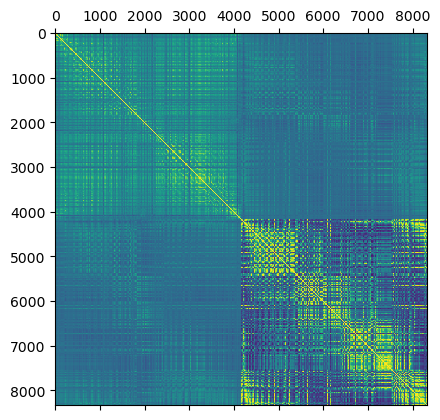

In [7]:
plt.matshow(corr_mat_v1)

In [9]:
# Since we are only interested in the correlation b/w betas_valid and Y_hat and not between themselves, let's remove the irrelevant entries 
rel_size = (corr_mat_v1.shape[0])// 2
corr_mat_rel_v1 = corr_mat_v1[rel_size:,:rel_size]

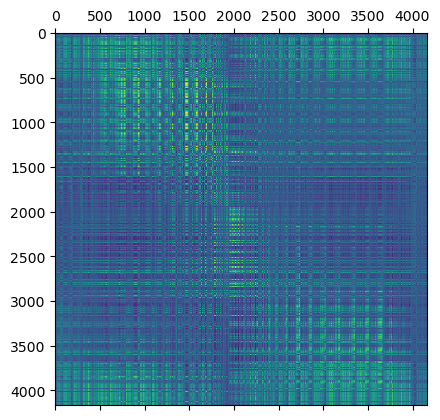

In [10]:
plt.matshow(corr_mat_rel_v1)

### V2

In [11]:
corr_mat_v2 = gen_corr_w_beta('v2')

Computing correlation for v2
K matrix: (4388, 180625)
Betas matrix before valid: (27751, 8296)
Valid indices shape: (4388,)
Betas matrix: (27750, 4388)
Y_hat matrix: (27750, 4388)


(8776, 8776)


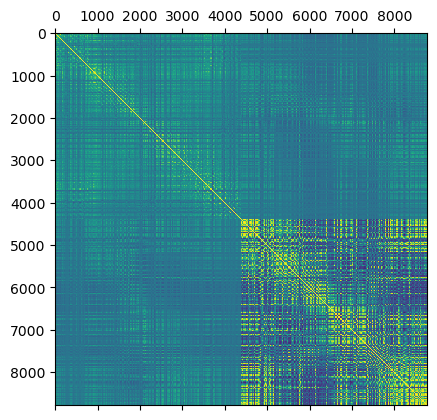

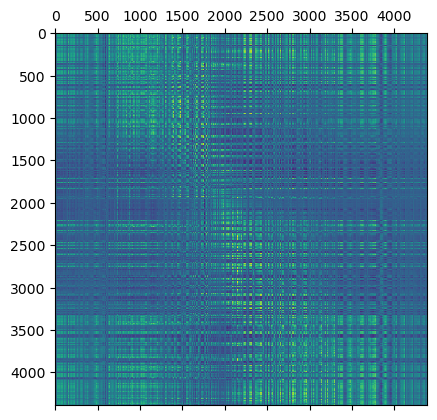

In [12]:
print(corr_mat_v2.shape)
rel_size = (corr_mat_v2.shape[0])// 2
corr_mat_rel_v2 = corr_mat_v2[rel_size:,:rel_size]
plt.matshow(corr_mat_v2)
plt.matshow(corr_mat_rel_v2)


### V3

In [13]:
corr_mat_v3 = gen_corr_w_beta('v3')

Computing correlation for v3
K matrix: (3311, 180625)
Betas matrix before valid: (27751, 7022)
Valid indices shape: (3311,)
Betas matrix: (27750, 3311)
Y_hat matrix: (27750, 3311)


(6622, 6622)


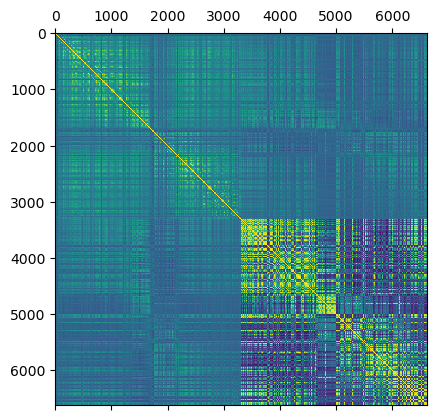

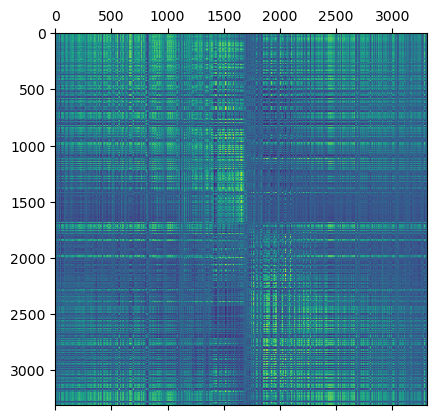

In [14]:
print(corr_mat_v3.shape)
rel_size = (corr_mat_v3.shape[0])// 2

corr_mat_rel_v3 = corr_mat_v3[rel_size:,:rel_size]
plt.matshow(corr_mat_v3)
plt.matshow(corr_mat_rel_v3)


### V4

In [15]:
corr_mat_v4 = gen_corr_w_beta('v4')

Computing correlation for v4
K matrix: (2615, 180625)
Betas matrix before valid: (27751, 3976)
Valid indices shape: (2615,)
Betas matrix: (27750, 2615)
Y_hat matrix: (27750, 2615)


(5230, 5230)


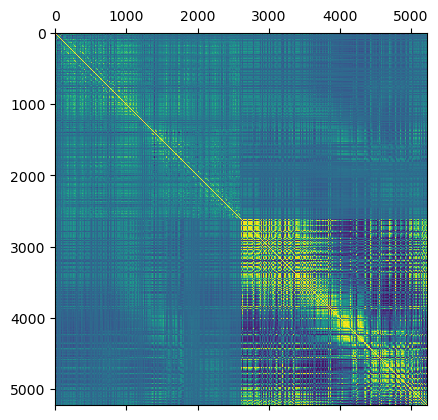

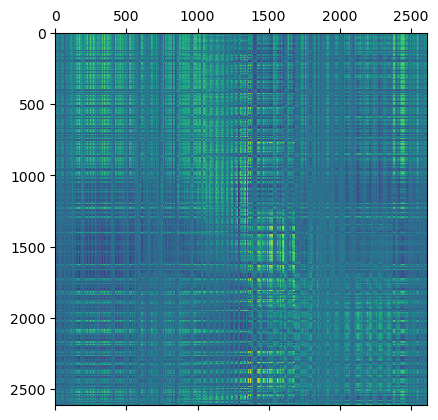

In [16]:
print(corr_mat_v4.shape)
rel_size = (corr_mat_v4.shape[0])// 2

corr_mat_rel_v4 = corr_mat_v4[rel_size:,:rel_size]
plt.matshow(corr_mat_v4)
plt.matshow(corr_mat_rel_v4)


# Extend to all ROIs 

We are interested in the diagonal elements 

Since we only need the correlation of a specific voxel with its activity; we can discard the non-diagnonal elements.

Because we only require the case when `i == j`, where `i` and `j` are the indices of the correlation matrix 

In [6]:
def generate_corr_full(roi_list, S_mat, print_log = True):
    '''
    Generate the correlation coeff for the given list of ROIs and return it as a dataframe 
    '''
    corr_vals = {}
    
    for roi in roi_list:
        corr_mat_roi = gen_corr_w_beta(roi = roi, S_mat = S_mat, print_log = print_log) 
        rel_size = (corr_mat_roi.shape[0])// 2
        corr_mat_rel_roi = corr_mat_roi[rel_size:,:rel_size]
        corr_vals[roi] = corr_mat_rel_roi.diagonal() 
        
    
    # Create a main dataframe to which all smaller dataframes (for each ROI) will be appended 
    df_main = pd.DataFrame(columns = ['ROI','corr_coeff'])
    
    for key,val in corr_vals.items(): # Key: ROI, value: array of correlations
        roi_as_list = [key] * val.shape[0] # duplicate the roi string so that it's in the format we want 
        corr_val_list = val
        temp_df = pd.DataFrame({'ROI': roi_as_list, 'corr_coeff':corr_val_list})   
        df_main = pd.concat((df_main, temp_df))
        
    return df_main

In [7]:
viz_roi_list = ["v1","v2","v3","v4"]
floc_faces_roi_list = ["ofa","ffa1", "ffa2", "atl"]
floc_words_roi_list = ["eba","fba1", "fba2"]
floc_places_roi_list = ["opa", "ppa", "rsc"]
floc_bodies_roi_list = ["owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words"]

ventral_temporal_roi_list = ["vo1","vo2","phc1","phc2"]
dorso_lateral_roi_list = ["v3a","v3b","lo2","lo1"]
pareital_frontal_roi_list = ["ips0","ips1","ips2","ips3","ips4","ips5","spl1","fef"]
       


In [8]:
sns.set_style("whitegrid")


In [9]:
corr_df_viz = generate_corr_full(viz_roi_list, S_mat)

Computing correlation for v1

K matrix: (4165, 180625)
Betas matrix before valid: (27751, 7887)
Valid indices shape: (4165,)
Betas matrix: (27750, 4165)
Y_hat matrix: (27750, 4165)


Computing correlation for v2

K matrix: (4388, 180625)
Betas matrix before valid: (27751, 8296)
Valid indices shape: (4388,)
Betas matrix: (27750, 4388)
Y_hat matrix: (27750, 4388)


Computing correlation for v3

K matrix: (3311, 180625)
Betas matrix before valid: (27751, 7022)
Valid indices shape: (3311,)
Betas matrix: (27750, 3311)
Y_hat matrix: (27750, 3311)


Computing correlation for v4

K matrix: (2615, 180625)
Betas matrix before valid: (27751, 3976)
Valid indices shape: (2615,)
Betas matrix: (27750, 2615)
Y_hat matrix: (27750, 2615)




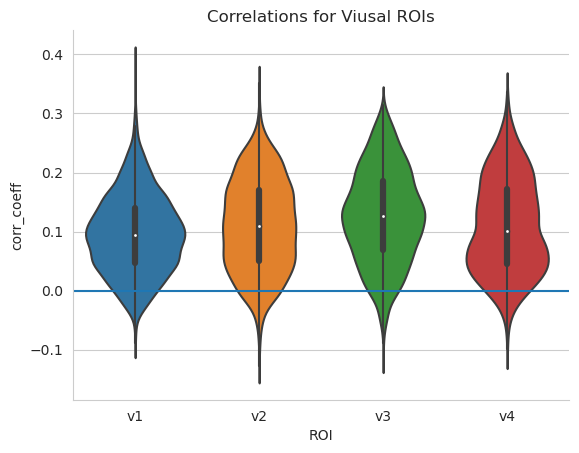

In [10]:
g = sns.violinplot(data = corr_df_viz, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for Viusal ROIs');

In [11]:
corr_df_faces = generate_corr_full(roi_list = floc_faces_roi_list, S_mat = S_mat)

Computing correlation for ofa

K matrix: (1889, 180625)
Betas matrix before valid: (27751, 2077)
Valid indices shape: (1889,)
Betas matrix: (27750, 1889)
Y_hat matrix: (27750, 1889)


Computing correlation for ffa1

K matrix: (1966, 180625)
Betas matrix before valid: (27751, 2854)
Valid indices shape: (1966,)
Betas matrix: (27750, 1966)
Y_hat matrix: (27750, 1966)


Computing correlation for ffa2

K matrix: (1344, 180625)
Betas matrix before valid: (27751, 1823)
Valid indices shape: (1344,)
Betas matrix: (27750, 1344)
Y_hat matrix: (27750, 1344)


Computing correlation for atl

K matrix: (404, 180625)
Betas matrix before valid: (27751, 935)
Valid indices shape: (404,)
Betas matrix: (27750, 404)
Y_hat matrix: (27750, 404)




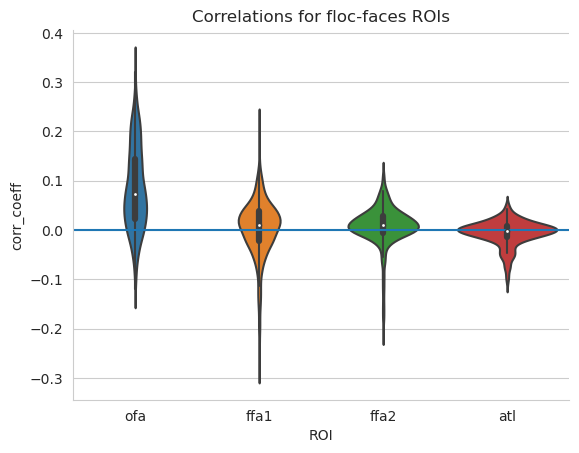

In [12]:
g = sns.violinplot(data = corr_df_faces, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for floc-faces ROIs');

In [13]:
corr_df_words = generate_corr_full(roi_list = floc_words_roi_list, S_mat = S_mat)

Computing correlation for eba

K matrix: (8663, 180625)
Betas matrix before valid: (27751, 17406)
Valid indices shape: (8663,)
Betas matrix: (27750, 8663)
Y_hat matrix: (27750, 8663)


Computing correlation for fba1

K matrix: (1378, 180625)
Betas matrix before valid: (27751, 2294)
Valid indices shape: (1378,)
Betas matrix: (27750, 1378)
Y_hat matrix: (27750, 1378)


Computing correlation for fba2

K matrix: (1935, 180625)
Betas matrix before valid: (27751, 2539)
Valid indices shape: (1935,)
Betas matrix: (27750, 1935)
Y_hat matrix: (27750, 1935)




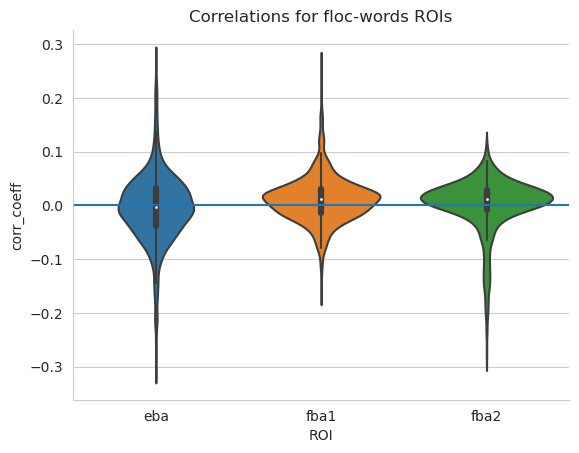

In [14]:
g = sns.violinplot(data = corr_df_words, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for floc-words ROIs');

In [15]:
corr_df_places = generate_corr_full(roi_list = floc_places_roi_list, S_mat = S_mat)

Computing correlation for opa

K matrix: (5960, 180625)
Betas matrix before valid: (27751, 9393)
Valid indices shape: (5960,)
Betas matrix: (27750, 5960)
Y_hat matrix: (27750, 5960)


Computing correlation for ppa

K matrix: (2456, 180625)
Betas matrix before valid: (27751, 5927)
Valid indices shape: (2456,)
Betas matrix: (27750, 2456)
Y_hat matrix: (27750, 2456)


Computing correlation for rsc

K matrix: (1438, 180625)
Betas matrix before valid: (27751, 3360)
Valid indices shape: (1438,)
Betas matrix: (27750, 1438)
Y_hat matrix: (27750, 1438)




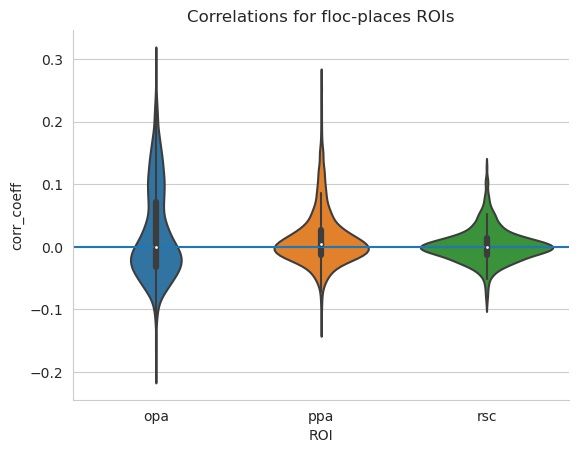

In [16]:
g = sns.violinplot(data = corr_df_places, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for floc-places ROIs');

In [17]:
corr_df_bodies = generate_corr_full(roi_list = floc_bodies_roi_list, S_mat = S_mat)

Computing correlation for owfa

K matrix: (2521, 180625)
Betas matrix before valid: (27751, 2701)
Valid indices shape: (2521,)
Betas matrix: (27750, 2521)
Y_hat matrix: (27750, 2521)


Computing correlation for vwfa_1

K matrix: (3613, 180625)
Betas matrix before valid: (27751, 4671)
Valid indices shape: (3613,)
Betas matrix: (27750, 3613)
Y_hat matrix: (27750, 3613)


Computing correlation for vwfa_2

K matrix: (2246, 180625)
Betas matrix before valid: (27751, 3009)
Valid indices shape: (2246,)
Betas matrix: (27750, 2246)
Y_hat matrix: (27750, 2246)


Computing correlation for mfs_words

K matrix: (570, 180625)
Betas matrix before valid: (27751, 973)
Valid indices shape: (570,)
Betas matrix: (27750, 570)
Y_hat matrix: (27750, 570)


Computing correlation for mtl_words

K matrix: (219, 180625)
Betas matrix before valid: (27751, 675)
Valid indices shape: (219,)
Betas matrix: (27750, 219)
Y_hat matrix: (27750, 219)




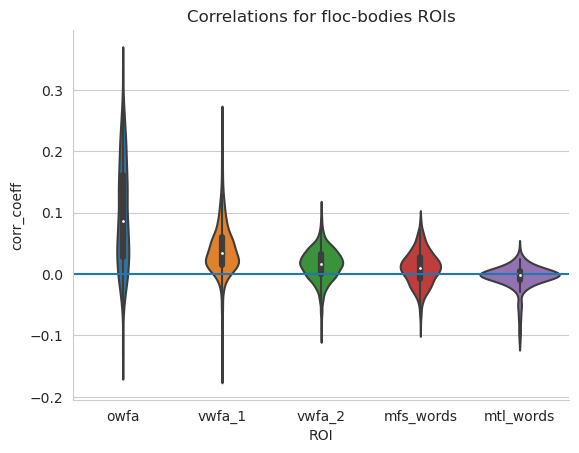

In [18]:
g = sns.violinplot(data = corr_df_bodies, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for floc-bodies ROIs');

In [19]:
corr_df_ventral_temporal = generate_corr_full(roi_list = ventral_temporal_roi_list, S_mat = S_mat)

Computing correlation for vo1

K matrix: (381, 180625)
Betas matrix before valid: (27751, 1263)
Valid indices shape: (381,)
Betas matrix: (27750, 381)
Y_hat matrix: (27750, 381)


Computing correlation for vo2

K matrix: (1201, 180625)
Betas matrix before valid: (27751, 1839)
Valid indices shape: (1201,)
Betas matrix: (27750, 1201)
Y_hat matrix: (27750, 1201)


Computing correlation for phc1

K matrix: (640, 180625)
Betas matrix before valid: (27751, 1141)
Valid indices shape: (640,)
Betas matrix: (27750, 640)
Y_hat matrix: (27750, 640)


Computing correlation for phc2

K matrix: (629, 180625)
Betas matrix before valid: (27751, 1032)
Valid indices shape: (629,)
Betas matrix: (27750, 629)
Y_hat matrix: (27750, 629)




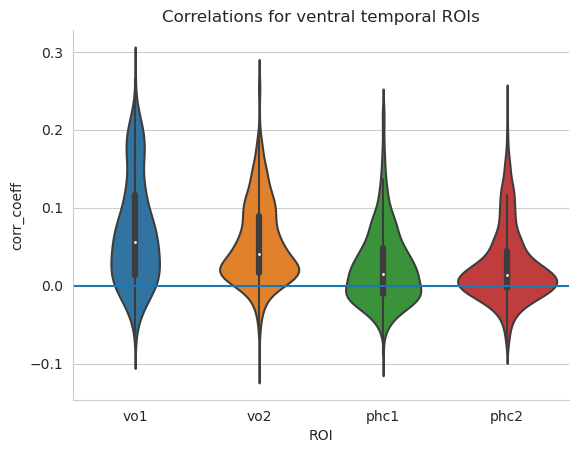

In [20]:
g = sns.violinplot(data = corr_df_ventral_temporal, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for ventral temporal ROIs');

In [21]:
corr_df_dorso_lateral = generate_corr_full(roi_list = dorso_lateral_roi_list, S_mat = S_mat)

Computing correlation for v3a

K matrix: (1020, 180625)
Betas matrix before valid: (27751, 3957)
Valid indices shape: (1020,)
Betas matrix: (27750, 1020)
Y_hat matrix: (27750, 1020)


Computing correlation for v3b

K matrix: (970, 180625)
Betas matrix before valid: (27751, 1830)
Valid indices shape: (970,)
Betas matrix: (27750, 970)
Y_hat matrix: (27750, 970)


Computing correlation for lo2

K matrix: (891, 180625)
Betas matrix before valid: (27751, 1099)
Valid indices shape: (891,)
Betas matrix: (27750, 891)
Y_hat matrix: (27750, 891)


Computing correlation for lo1

K matrix: (1569, 180625)
Betas matrix before valid: (27751, 1966)
Valid indices shape: (1569,)
Betas matrix: (27750, 1569)
Y_hat matrix: (27750, 1569)




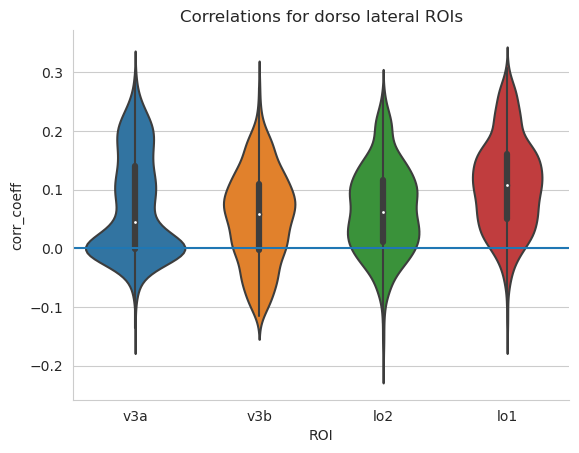

In [22]:
g = sns.violinplot(data = corr_df_dorso_lateral, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for dorso lateral ROIs');

In [23]:
# Kummerer paper on low level vs high level saliency
# luminance , staturation and constrast controls 

In [24]:
corr_df_pareital_frontal = generate_corr_full(roi_list = pareital_frontal_roi_list, S_mat = S_mat)


Computing correlation for ips0

K matrix: (2133, 180625)
Betas matrix before valid: (27751, 3450)
Valid indices shape: (2133,)
Betas matrix: (27750, 2133)
Y_hat matrix: (27750, 2133)


Computing correlation for ips1

K matrix: (2087, 180625)
Betas matrix before valid: (27751, 2755)
Valid indices shape: (2087,)
Betas matrix: (27750, 2087)
Y_hat matrix: (27750, 2087)


Computing correlation for ips2

K matrix: (1946, 180625)
Betas matrix before valid: (27751, 2969)
Valid indices shape: (1946,)
Betas matrix: (27750, 1946)
Y_hat matrix: (27750, 1946)


Computing correlation for ips3

K matrix: (2185, 180625)
Betas matrix before valid: (27751, 2960)
Valid indices shape: (2185,)
Betas matrix: (27750, 2185)
Y_hat matrix: (27750, 2185)


Computing correlation for ips4

K matrix: (272, 180625)
Betas matrix before valid: (27751, 361)
Valid indices shape: (272,)
Betas matrix: (27750, 272)
Y_hat matrix: (27750, 272)


Computing correlation for ips5

K matrix: (53, 180625)
Betas matrix before valid

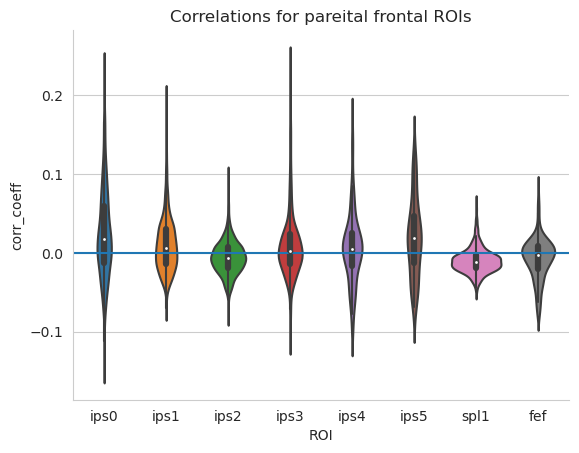

In [25]:
g = sns.violinplot(data = corr_df_pareital_frontal, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for pareital frontal ROIs');

In [26]:
list_a = ["v3a","v3b", "ips0","ips1","ips2","ips3","ips4","ips5", "spl1","fef"]
list_b = ["vo1","vo2","lo1","lo2","phc1","phc2"]

In [27]:
corr_df_list_a = generate_corr_full(roi_list = list_a, S_mat = S_mat)


Computing correlation for v3a

K matrix: (1020, 180625)
Betas matrix before valid: (27751, 3957)
Valid indices shape: (1020,)
Betas matrix: (27750, 1020)
Y_hat matrix: (27750, 1020)


Computing correlation for v3b

K matrix: (970, 180625)
Betas matrix before valid: (27751, 1830)
Valid indices shape: (970,)
Betas matrix: (27750, 970)
Y_hat matrix: (27750, 970)


Computing correlation for ips0

K matrix: (2133, 180625)
Betas matrix before valid: (27751, 3450)
Valid indices shape: (2133,)
Betas matrix: (27750, 2133)
Y_hat matrix: (27750, 2133)


Computing correlation for ips1

K matrix: (2087, 180625)
Betas matrix before valid: (27751, 2755)
Valid indices shape: (2087,)
Betas matrix: (27750, 2087)
Y_hat matrix: (27750, 2087)


Computing correlation for ips2

K matrix: (1946, 180625)
Betas matrix before valid: (27751, 2969)
Valid indices shape: (1946,)
Betas matrix: (27750, 1946)
Y_hat matrix: (27750, 1946)


Computing correlation for ips3

K matrix: (2185, 180625)
Betas matrix before vali

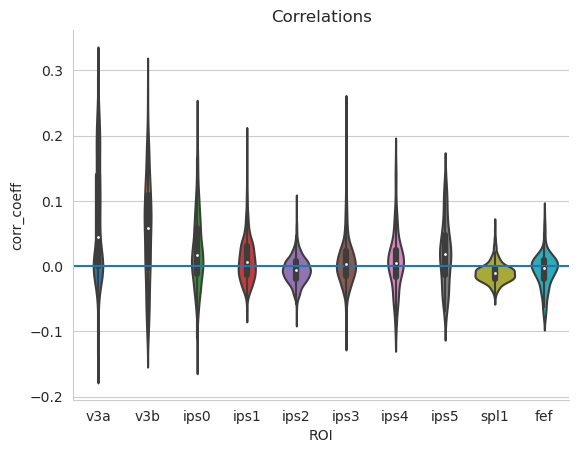

In [28]:
g = sns.violinplot(data = corr_df_list_a, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations');

In [29]:
corr_df_list_b = generate_corr_full(roi_list = list_b, S_mat = S_mat)


Computing correlation for vo1

K matrix: (381, 180625)
Betas matrix before valid: (27751, 1263)
Valid indices shape: (381,)
Betas matrix: (27750, 381)
Y_hat matrix: (27750, 381)


Computing correlation for vo2

K matrix: (1201, 180625)
Betas matrix before valid: (27751, 1839)
Valid indices shape: (1201,)
Betas matrix: (27750, 1201)
Y_hat matrix: (27750, 1201)


Computing correlation for lo1

K matrix: (1569, 180625)
Betas matrix before valid: (27751, 1966)
Valid indices shape: (1569,)
Betas matrix: (27750, 1569)
Y_hat matrix: (27750, 1569)


Computing correlation for lo2

K matrix: (891, 180625)
Betas matrix before valid: (27751, 1099)
Valid indices shape: (891,)
Betas matrix: (27750, 891)
Y_hat matrix: (27750, 891)


Computing correlation for phc1

K matrix: (640, 180625)
Betas matrix before valid: (27751, 1141)
Valid indices shape: (640,)
Betas matrix: (27750, 640)
Y_hat matrix: (27750, 640)


Computing correlation for phc2

K matrix: (629, 180625)
Betas matrix before valid: (27751, 

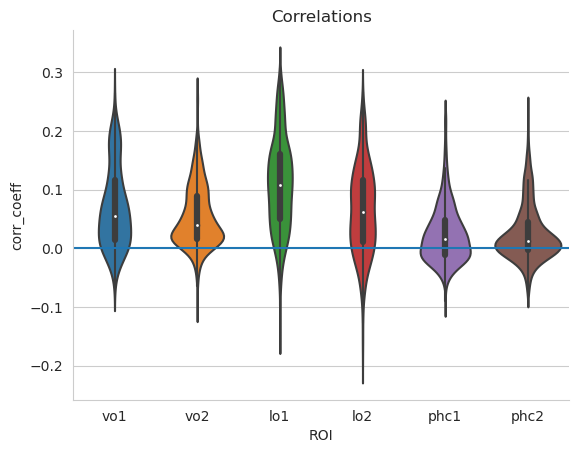

In [30]:
g = sns.violinplot(data = corr_df_list_b, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations');

# Low level correlations

Interesting to compare with high level too

## Edges

In [31]:
S_mat_edges = np.load(DATA_PATH+"/S_mat_edges.npy")

In [32]:
S_mat_edges = S_mat_edges[:27750,:]

In [33]:
def concat_df_with_type(df_list , type_list):
    '''
    Concatenate the corr dataframes such that they each have a colunn 'type' which contains the type of the data. 
    Such as DeepGaze, edge, lumninance, etc.
    
    '''
    df_main = pd.DataFrame(columns = ['ROI','corr_coeff', 'type'])
    
    for df, corr_type in zip(df_list, type_list):
        df_copy = df.copy()
        df_copy['type'] = corr_type
        df_main = df_main.append(df_copy)
    
    
    return df_main

### Visual ROIs

In [35]:
corr_df_viz_edges = generate_corr_full(viz_roi_list, S_mat_edges, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [36]:
corr_df_joined = concat_df_with_type(df_list = [corr_df_viz_edges, corr_df_viz] , type_list = ["edges" , "deepgaze"]) 

/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


In [37]:
corr_df_joined

ROI  corr_coeff      type
0     v1    0.017341     edges
1     v1    0.052680     edges
2     v1    0.037271     edges
3     v1    0.020557     edges
4     v1    0.088093     edges
...   ..         ...       ...
2610  v4   -0.007521  deepgaze
2611  v4    0.057328  deepgaze
2612  v4    0.026452  deepgaze
2613  v4   -0.024242  deepgaze
2614  v4    0.001303  deepgaze

[28958 rows x 3 columns]

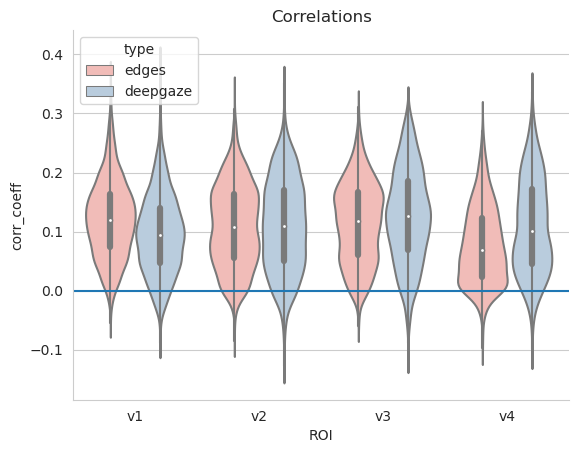

In [38]:
g = sns.violinplot(data = corr_df_joined, x = "ROI" , y = "corr_coeff", hue = "type", palette = "Pastel1")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations');

In [39]:
def plot_corr_violinplot(df ,title = "Correlation" , palette = "Pastel1"):
    g = sns.violinplot(data = df, x = "ROI" , y = "corr_coeff", hue = "type", palette = palette)
    sns.despine()
    g.axhline(0)
    g.set(title = title);
    

In [ ]:
# # viz_roi_list = ["v1","v2","v3","v4"]
# floc_faces_roi_list = ["ofa","ffa1", "ffa2", "atl"]
# floc_words_roi_list = ["eba","fba1", "fba2"]
# floc_places_roi_list = ["opa", "ppa", "rsc"]
# floc_bodies_roi_list = ["owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words"]

# ventral_temporal_roi_list = ["vo1","vo2","phc1","phc2"]
# dorso_lateral_roi_list = ["v3a","v3b","lo2","lo1"]
# pareital_frontal_roi_list = ["ips0","ips1","ips2","ips3","ips4","ips5","spl1","fef"]
       


### floc-faces

In [40]:
corr_df_faces_edges = generate_corr_full(floc_faces_roi_list, S_mat_edges, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [41]:
df_tst =  concat_df_with_type(df_list = [corr_df_faces, corr_df_faces_edges] , type_list = ["edges" , "deepgaze"])

/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


In [42]:
df_tst

ROI  corr_coeff      type
0    ofa   -0.038034     edges
1    ofa    0.015703     edges
2    ofa    0.008389     edges
3    ofa    0.088463     edges
4    ofa    0.020113     edges
..   ...         ...       ...
399  atl    0.001952  deepgaze
400  atl   -0.002796  deepgaze
401  atl   -0.010882  deepgaze
402  atl   -0.004157  deepgaze
403  atl   -0.013536  deepgaze

[11206 rows x 3 columns]

/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


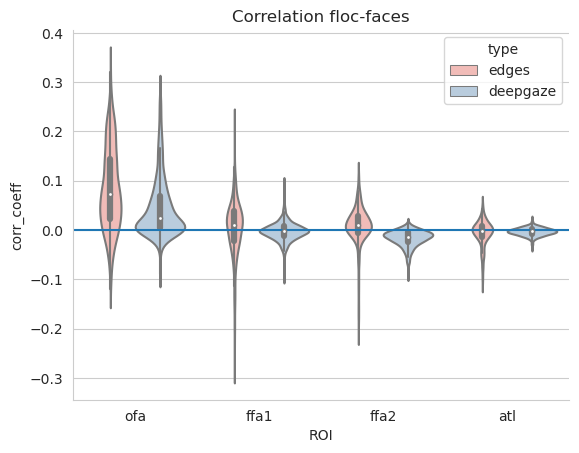

In [43]:
plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_faces, corr_df_faces_edges] , type_list = ["edges" , "deepgaze"]), 
                     title = "Correlation floc-faces")

### floc-words

In [44]:
corr_df_words_edges = generate_corr_full(floc_words_roi_list, S_mat_edges, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


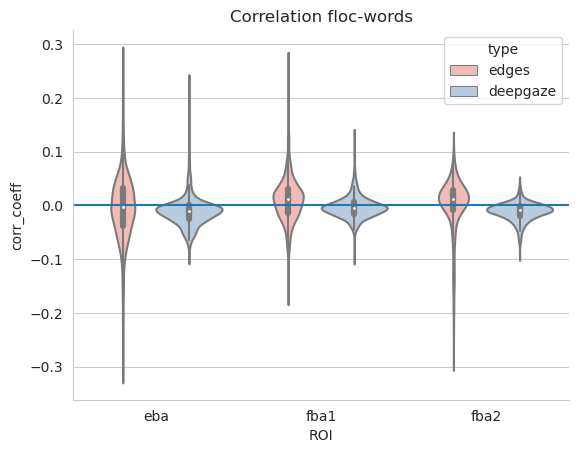

In [45]:
plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_words, corr_df_words_edges] , type_list = ["edges" , "deepgaze"]), 
                     title = "Correlation floc-words")

### floc-places

In [46]:
corr_df_places_edges = generate_corr_full(floc_places_roi_list, S_mat_edges, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


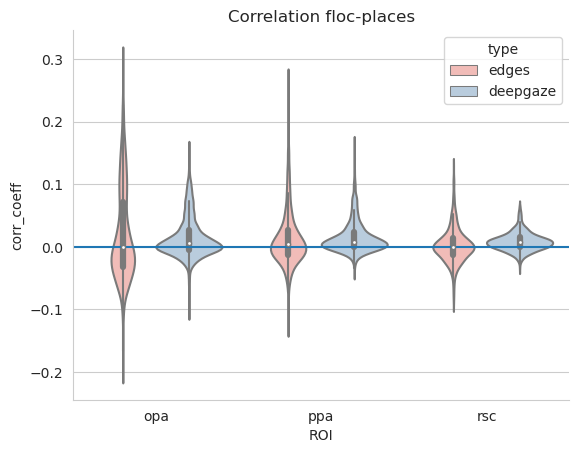

In [47]:
plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_places, corr_df_places_edges] , type_list = ["edges" , "deepgaze"]), 
                     title = "Correlation floc-places")

### floc-bodies

In [48]:
corr_df_bodies_edges = generate_corr_full(floc_bodies_roi_list, S_mat_edges, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


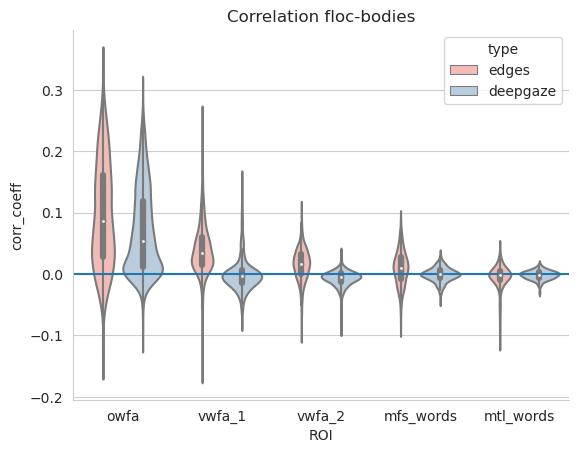

In [49]:
plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_bodies, corr_df_bodies_edges] , type_list = ["edges" , "deepgaze"]), 
                     title = "Correlation floc-bodies")

### list A

In [50]:
corr_df_listA_edges = generate_corr_full(list_a, S_mat_edges, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [51]:
corr_df_list_a

ROI  corr_coeff
0    v3a    0.035614
1    v3a    0.114418
2    v3a    0.137478
3    v3a    0.173578
4    v3a    0.220015
..   ...         ...
278  fef    0.002545
279  fef    0.007628
280  fef   -0.006630
281  fef    0.017127
282  fef   -0.005808

[11662 rows x 2 columns]

/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


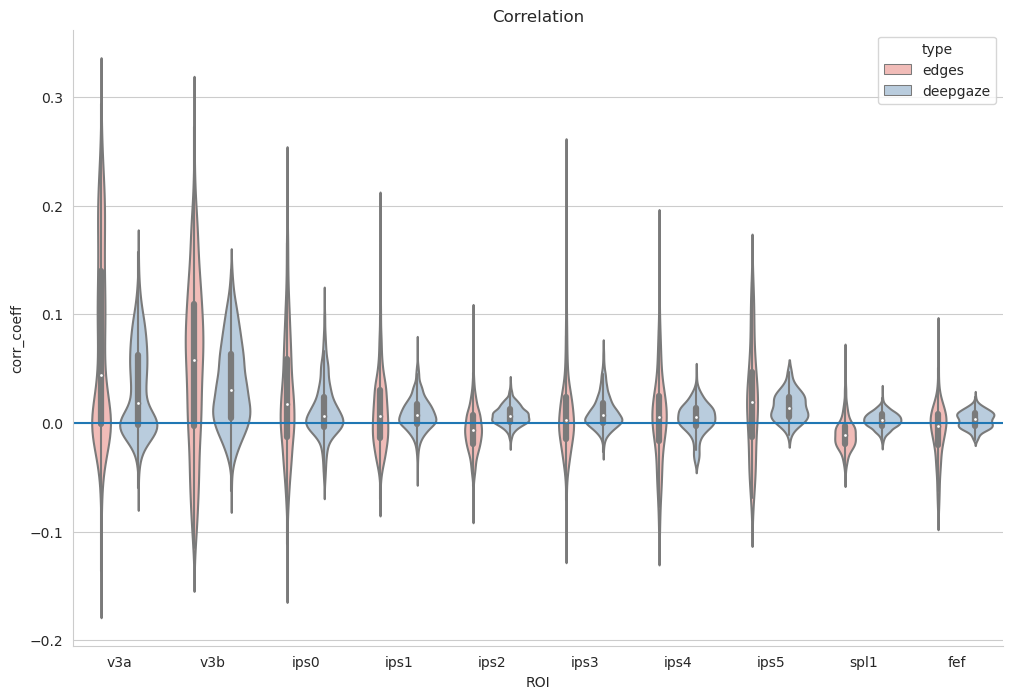

In [52]:
plt.figure(figsize=(12, 8))
plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_list_a, corr_df_listA_edges] , type_list = ["edges" , "deepgaze"]), 
                     title = "Correlation")

### list B

In [53]:
corr_df_listB_edges = generate_corr_full(list_b, S_mat_edges, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


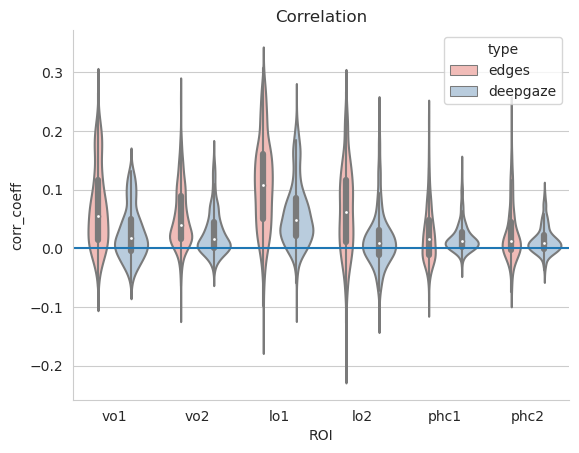

In [54]:
plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_list_b, corr_df_listB_edges] , type_list = ["edges" , "deepgaze"]), 
                     title = "Correlation")

## Saturation and Luminance together

In [55]:
image_data_set = h5py.File(stim_file, 'r')

for key, value in image_data_set.items() :
    print(key,": \n", value,"\n")
    
image_data_73k = np.copy(image_data_set['imgBrick'])
image_data_set.close()

imgBrick : 
 <HDF5 dataset "imgBrick": shape (73000, 425, 425, 3), type "|u1"> 



In [56]:
img_indices = pd.read_pickle(DATA_PATH+"/img_indices.pkl")

In [57]:
S_mat_edges = np.load(DATA_PATH+"/S_mat_edges.npy")
S_mat_edges = S_mat_edges[:27750,:]

In [58]:
S_mat_saturation = np.load(DATA_PATH+"/S_mat_saturation.npy")
S_mat_saturation = S_mat_saturation[:27750,:]

In [59]:
S_mat_luminance = np.load(DATA_PATH+"/S_mat_luminance.npy")
S_mat_luminance = S_mat_luminance[:27750,:]

### Visual ROIs

In [155]:
corr_df_viz_saturation = generate_corr_full(viz_roi_list,S_mat_saturation, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



In [156]:
corr_df_viz_luminance = generate_corr_full(viz_roi_list, S_mat_luminance, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


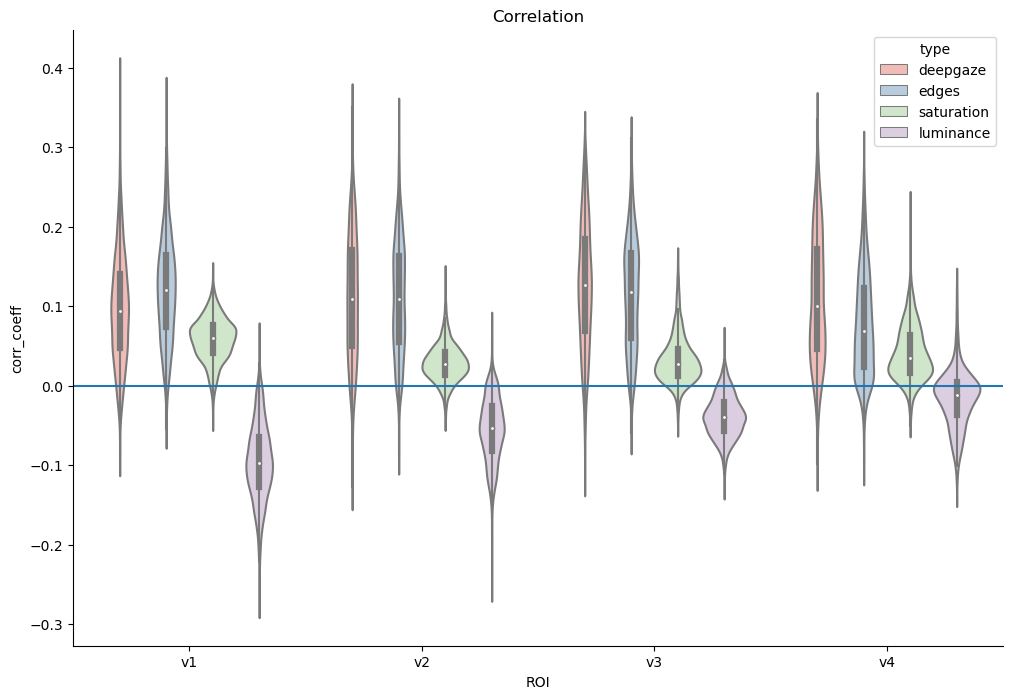

In [157]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_viz, corr_df_viz_edges, corr_df_viz_saturation, corr_df_viz_luminance],
                                        type_list = ["deepgaze", "edges", "saturation", "luminance"]) ,                   
                     title = "Correlation")

### floc-faces ROIs

In [158]:
corr_df_faces_saturation = generate_corr_full(floc_faces_roi_list,S_mat_saturation, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



In [159]:
corr_df_faces_luminance = generate_corr_full(floc_faces_roi_list, S_mat_luminance, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


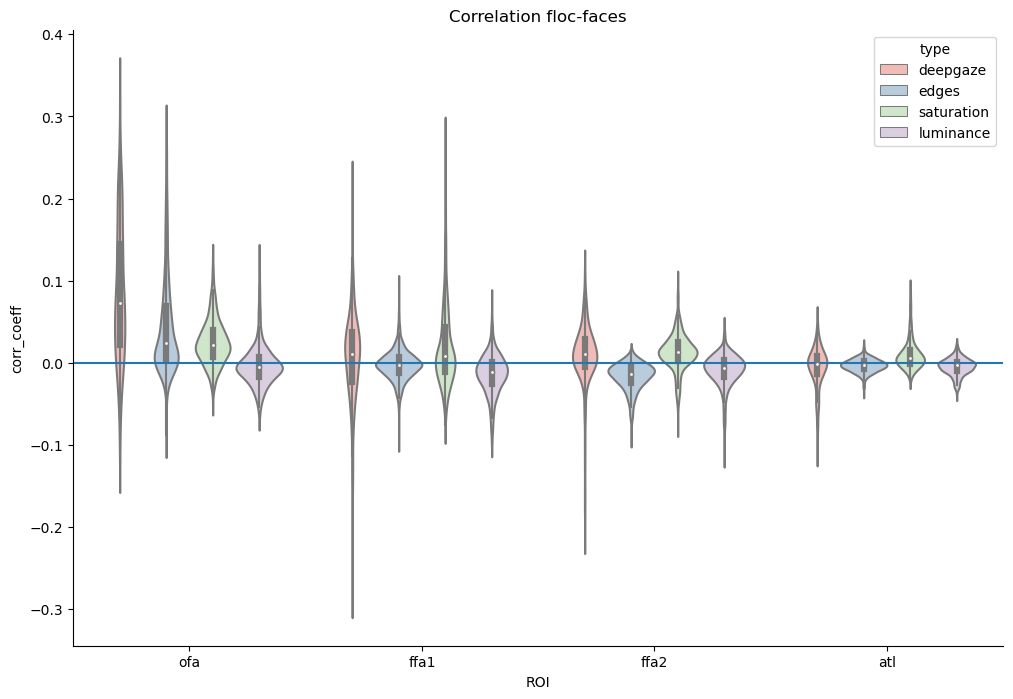

In [160]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_faces, corr_df_faces_edges, corr_df_faces_saturation, corr_df_faces_luminance],
                                        type_list = ["deepgaze", "edges", "saturation", "luminance"]) ,                   
                     title = "Correlation floc-faces")

### floc-bodies ROIs

In [161]:
corr_df_bodies_saturation = generate_corr_full(floc_bodies_roi_list,S_mat_saturation, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



In [162]:
corr_df_bodies_luminance = generate_corr_full(floc_bodies_roi_list, S_mat_luminance, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


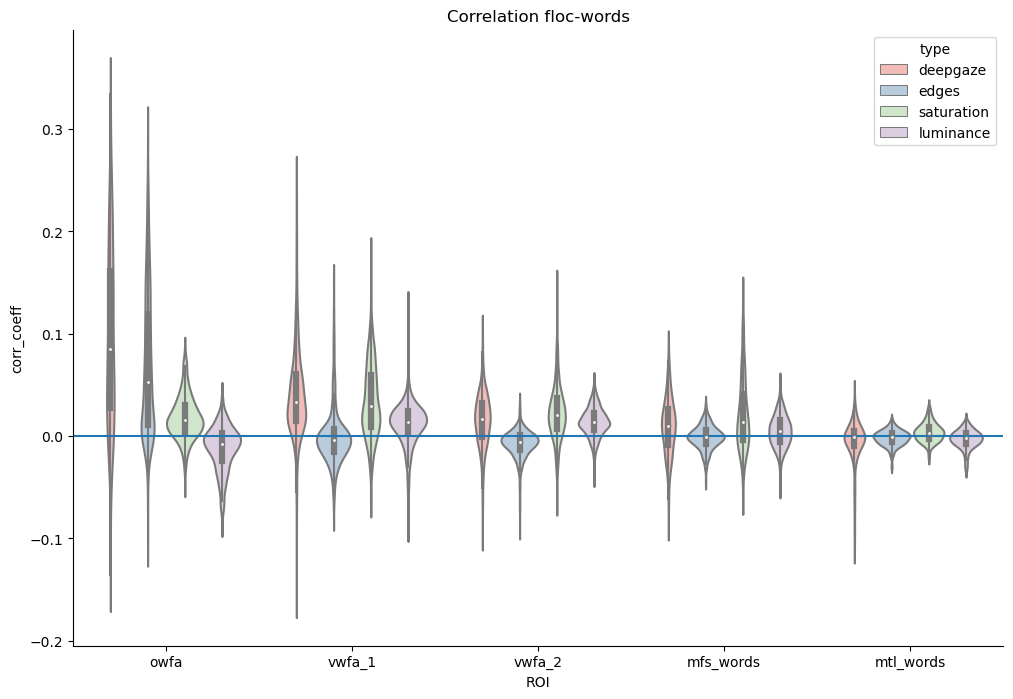

In [163]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_bodies, corr_df_bodies_edges, corr_df_bodies_saturation, corr_df_bodies_luminance],
                                        type_list = ["deepgaze", "edges", "saturation", "luminance"]) ,                   
                     title = "Correlation floc-words")

### floc-places ROIs

In [164]:
corr_df_places_saturation = generate_corr_full(floc_places_roi_list,S_mat_saturation, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



In [165]:
corr_df_places_luminance = generate_corr_full(floc_places_roi_list, S_mat_luminance, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


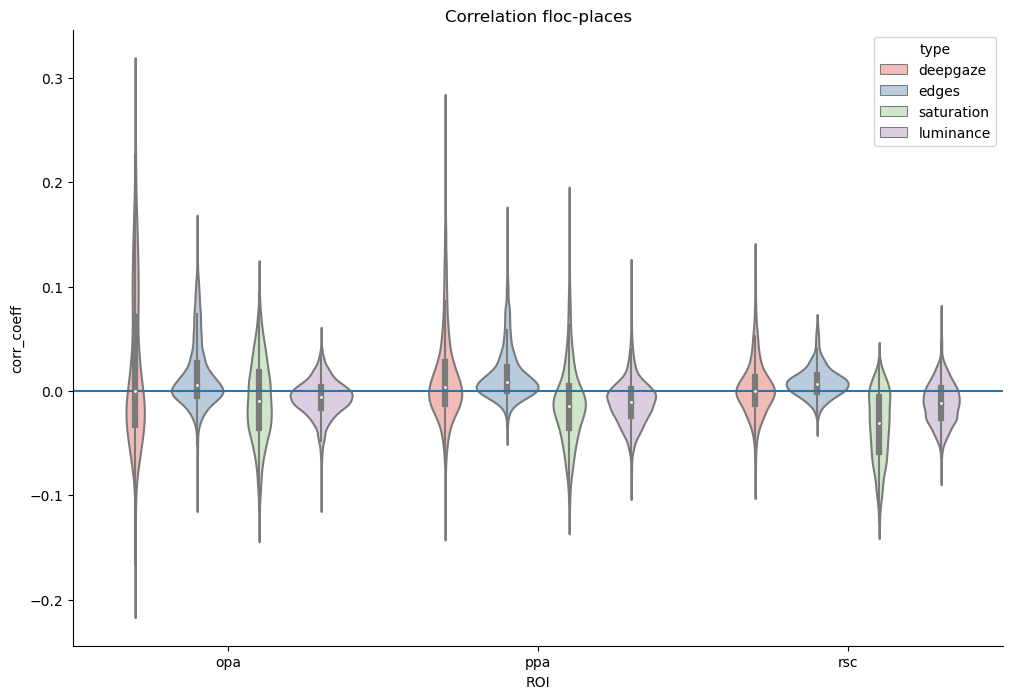

In [166]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_places, corr_df_places_edges, corr_df_places_saturation, corr_df_places_luminance],
                                        type_list = ["deepgaze", "edges", "saturation", "luminance"]) ,                   
                     title = "Correlation floc-places")

### floc-words ROIs

In [167]:
corr_df_words_saturation = generate_corr_full(floc_words_roi_list,S_mat_saturation, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



In [168]:
corr_df_words_luminance = generate_corr_full(floc_words_roi_list, S_mat_luminance, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


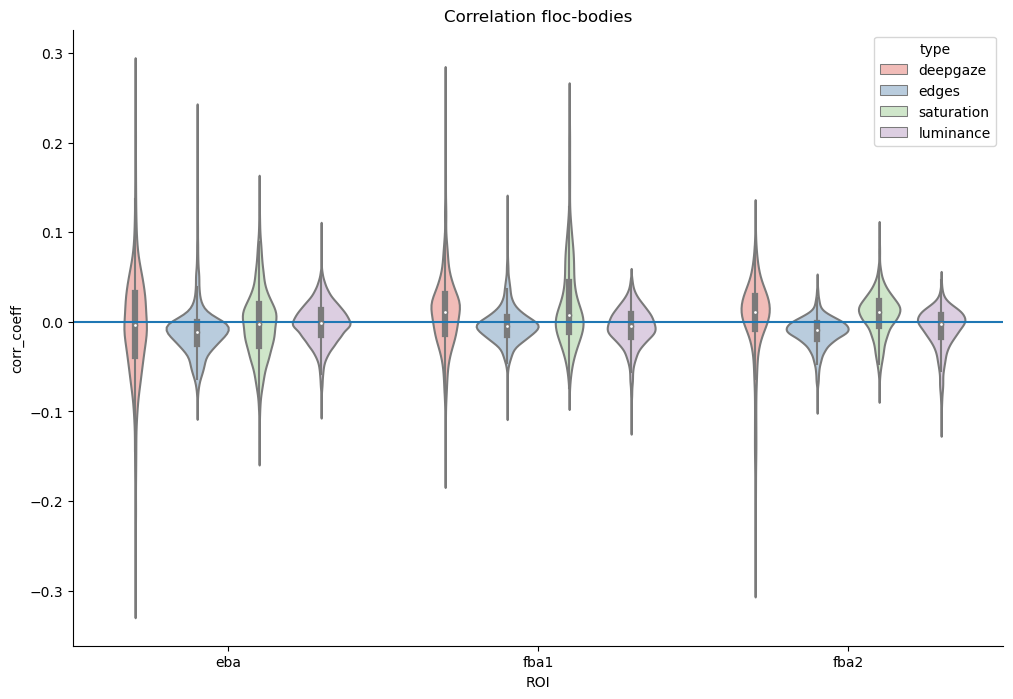

In [169]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_words, corr_df_words_edges, corr_df_words_saturation, corr_df_words_luminance],
                                        type_list = ["deepgaze", "edges", "saturation", "luminance"]) ,                   
                     title = "Correlation floc-bodies")

### List A and B 

In [170]:
corr_df_listA_saturation = generate_corr_full(list_a, S_mat_saturation, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



In [171]:
corr_df_listA_luminance = generate_corr_full(list_a, S_mat_luminance, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


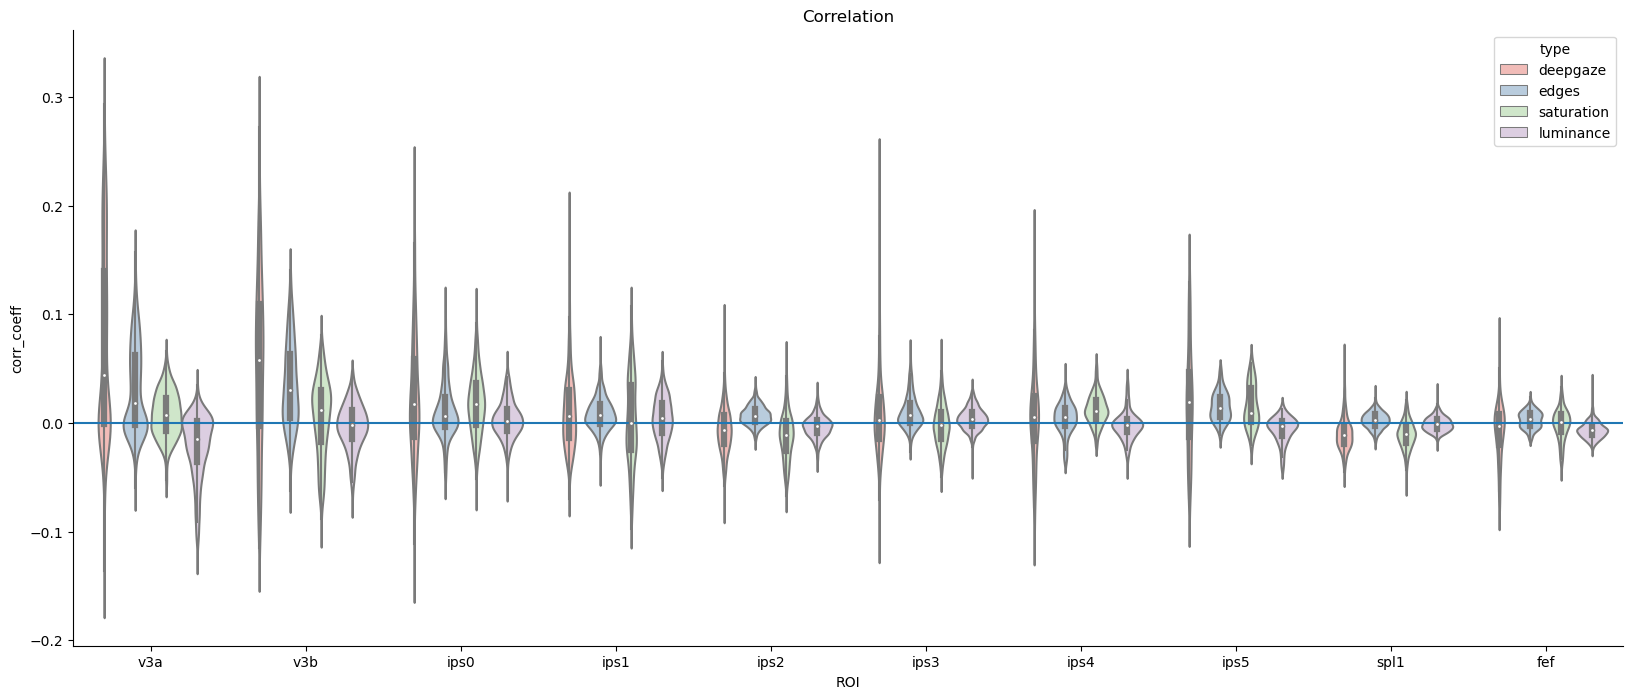

In [172]:
plt.figure(figsize=(20,8))

plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_list_a, corr_df_listA_edges, corr_df_listA_saturation, corr_df_listA_luminance],
                                        type_list = ["deepgaze", "edges", "saturation", "luminance"]) ,                   
                     title = "Correlation")

In [173]:
corr_df_listB_saturation = generate_corr_full(list_b, S_mat_saturation, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



In [174]:
corr_df_listB_luminance = generate_corr_full(list_b, S_mat_luminance, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)


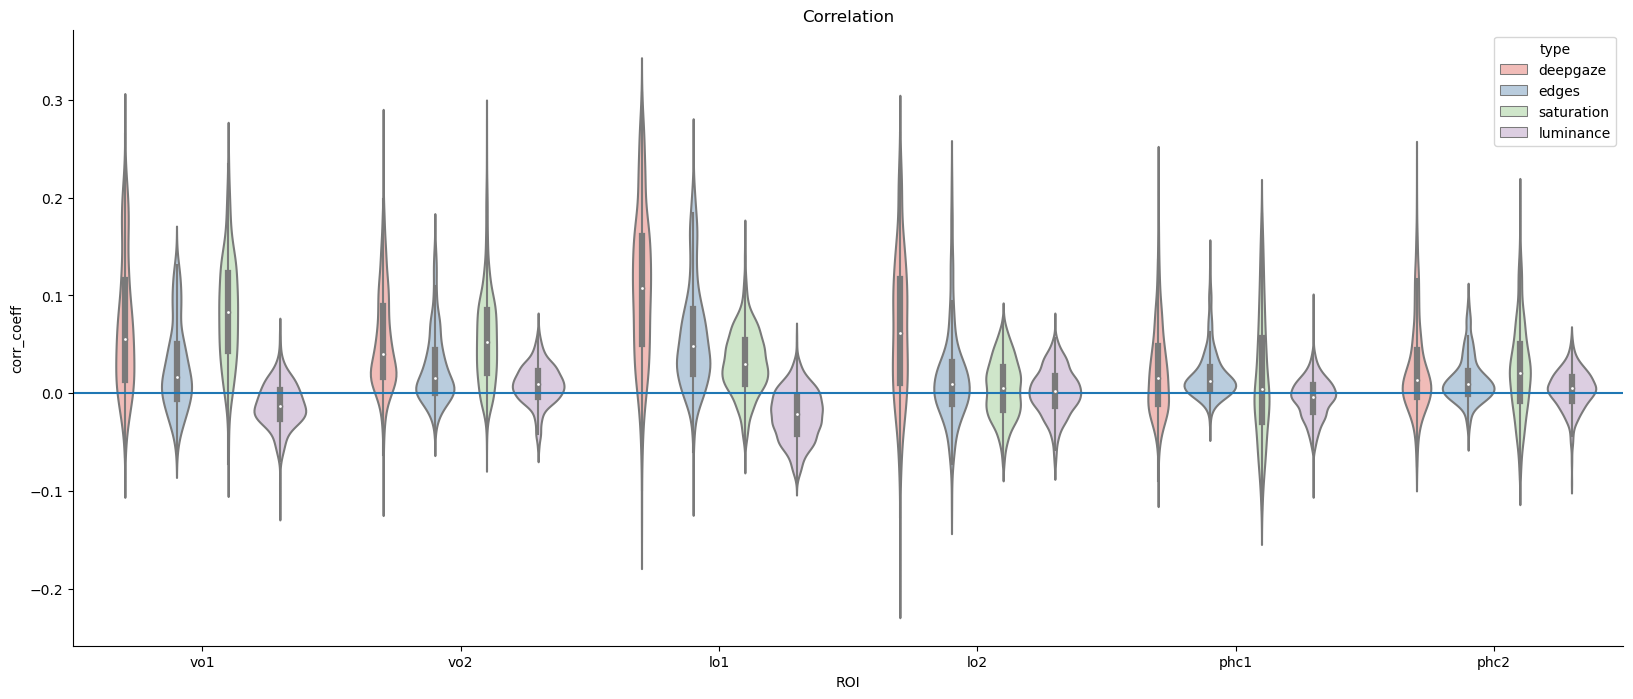

In [175]:
plt.figure(figsize=(20,8))

plot_corr_violinplot(df = concat_df_with_type(df_list = [corr_df_list_b, corr_df_listB_edges, corr_df_listB_saturation, corr_df_listB_luminance],
                                        type_list = ["deepgaze", "edges", "saturation", "luminance"]) ,                   
                     title = "Correlation")

## Itti & Koch Saliency maps 

These maps are generated with SaliencyToolbox in MATLAB and then imported here

In [62]:
import scipy.io

In [146]:
ittikoch_maps_dataset = h5py.File(DATA_PATH + "/salmaps_all.mat", 'r')

In [147]:
for key, value in ittikoch_maps_datast.items() :
    print(key,": \n", value,"\n")
    

ittikoch_maps = np.copy(ittikoch_maps_dataset['salmaplist'])
ittikoch_maps_dataset.close()

salmaplist : 
 <HDF5 dataset "salmaplist": shape (180625, 30000), type "<f4"> 



In [148]:
num_pixels = 425 
num_images = 30000

# The saliency maps are actually flipped and mirrored. So we undo that operation by transposing them 

ittikoch_maps = ittikoch_maps.reshape(num_pixels, num_pixels, num_images)
ittikoch_maps = ittikoch_maps.transpose(1, 0, 2)
ittikoch_maps = ittikoch_maps.reshape(-1, num_images).T

In [177]:
ittikoch_maps = ittikoch_maps[:27750,:]

In [154]:
# import matplotlib
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# %matplotlib inline

### Visual ROIs

In [179]:
corr_df_viz_itti = generate_corr_full(viz_roi_list, ittikoch_maps, print_log = False)

Computing correlation for v1

Computing correlation for v2

Computing correlation for v3

Computing correlation for v4



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

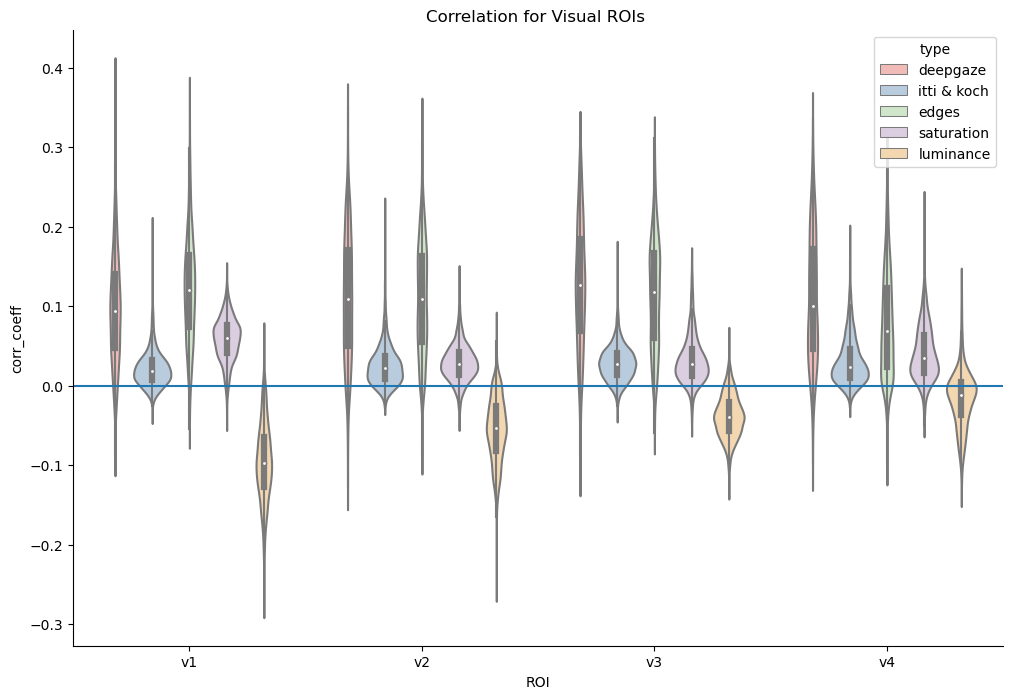

In [180]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                          df_list = [corr_df_viz, corr_df_viz_itti, corr_df_viz_edges, corr_df_viz_saturation, corr_df_viz_luminance],
                        type_list = ["deepgaze", "itti & koch" , "edges", "saturation", "luminance"]),                   
                            title = "Correlation for Visual ROIs ")

### floc-faces 

In [181]:
corr_df_faces_itti = generate_corr_full(floc_faces_roi_list, ittikoch_maps, print_log = False)

Computing correlation for ofa

Computing correlation for ffa1

Computing correlation for ffa2

Computing correlation for atl



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

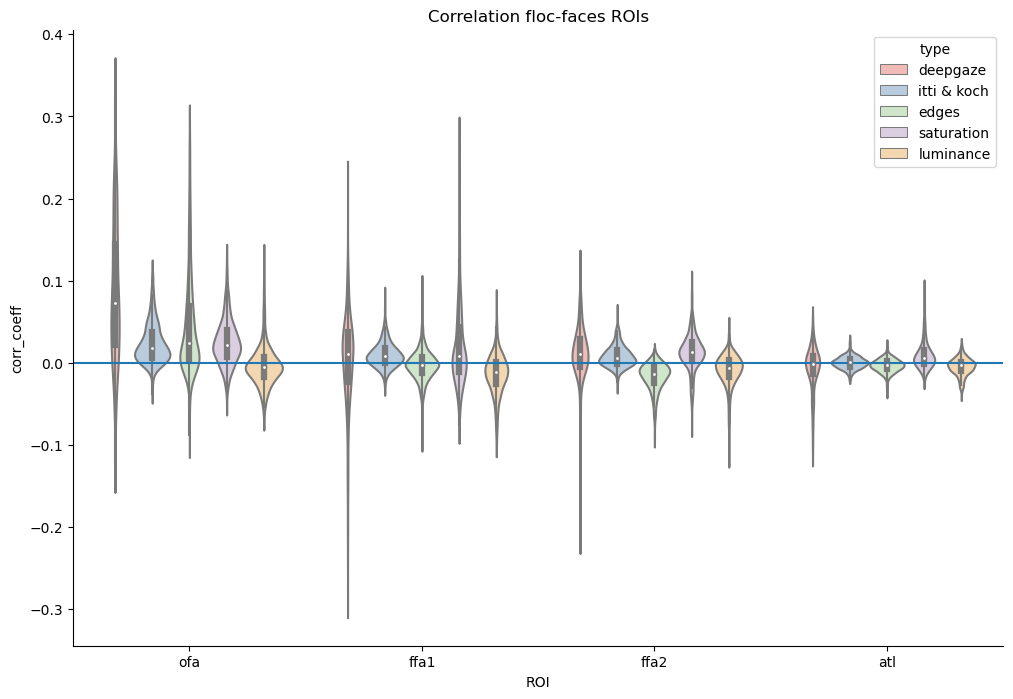

In [182]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                        df_list = [corr_df_faces, corr_df_faces_itti, corr_df_faces_edges, corr_df_faces_saturation, corr_df_faces_luminance],
                      type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]),                   
                          title = "Correlation floc-faces ROIs")

### floc-bodies

In [183]:
corr_df_bodies_itti = generate_corr_full(floc_bodies_roi_list, ittikoch_maps, print_log = False)

Computing correlation for owfa

Computing correlation for vwfa_1

Computing correlation for vwfa_2

Computing correlation for mfs_words

Computing correlation for mtl_words



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

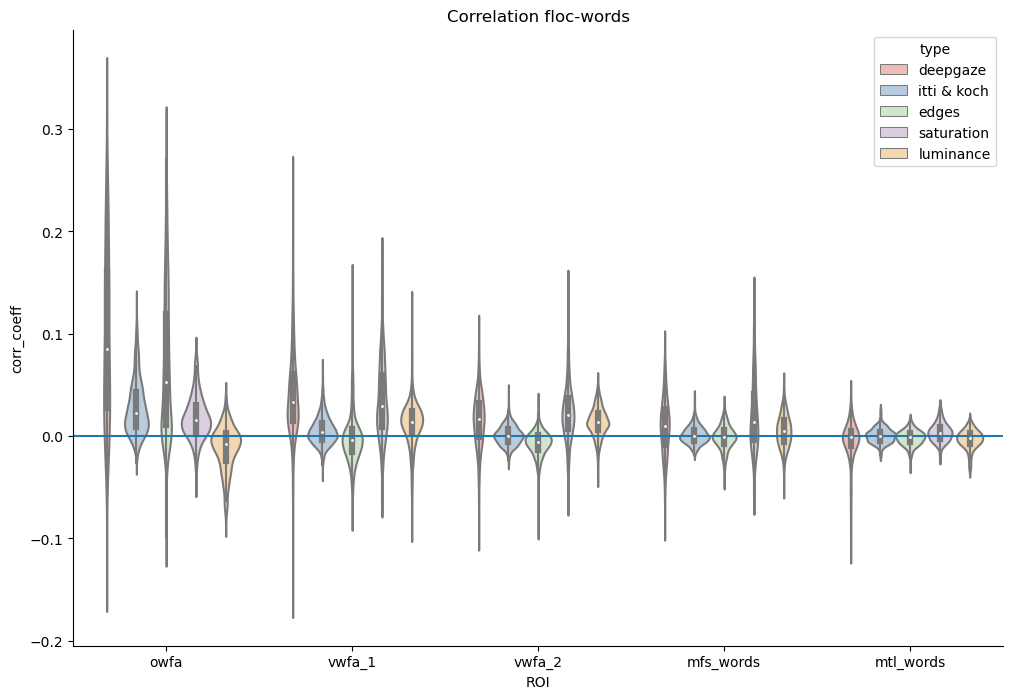

In [184]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_bodies, corr_df_bodies_itti, corr_df_bodies_edges, corr_df_bodies_saturation, corr_df_bodies_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]),                   
                      title = "Correlation floc-words ROIs")

### floc-places

In [185]:
corr_df_places_itti = generate_corr_full(floc_places_roi_list, ittikoch_maps, print_log = False)

Computing correlation for opa

Computing correlation for ppa

Computing correlation for rsc



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

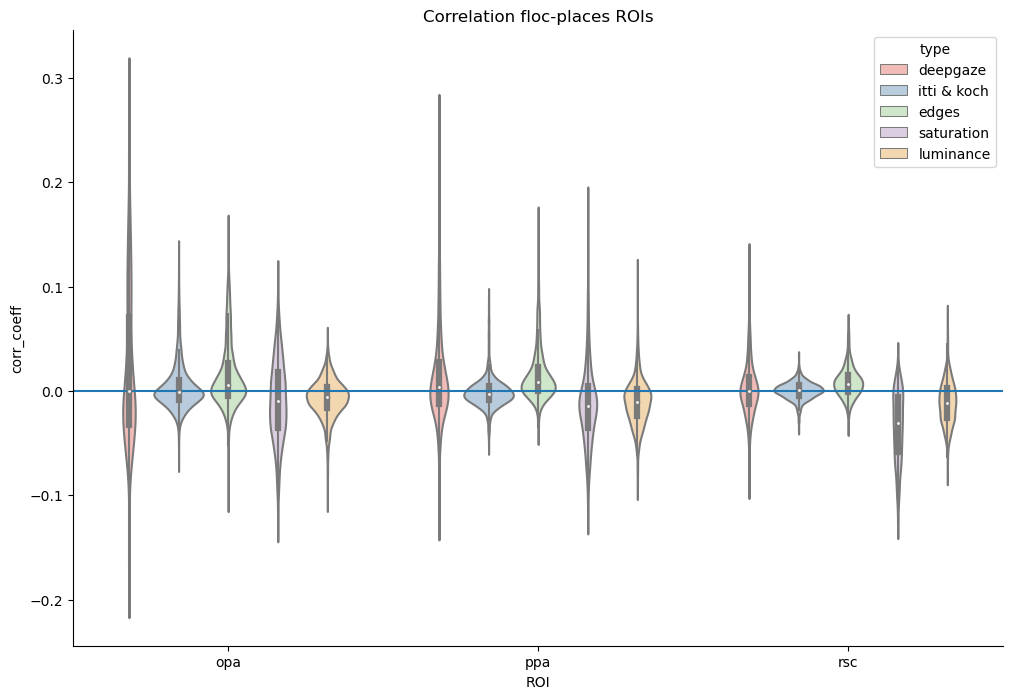

In [186]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_places, corr_df_places_itti, corr_df_places_edges, corr_df_places_saturation, corr_df_places_luminance],
                  type_list = ["deepgaze","itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation floc-places ROIs")

### floc-words

In [187]:
corr_df_words_itti = generate_corr_full(floc_words_roi_list, ittikoch_maps, print_log = False)

Computing correlation for eba

Computing correlation for fba1

Computing correlation for fba2



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

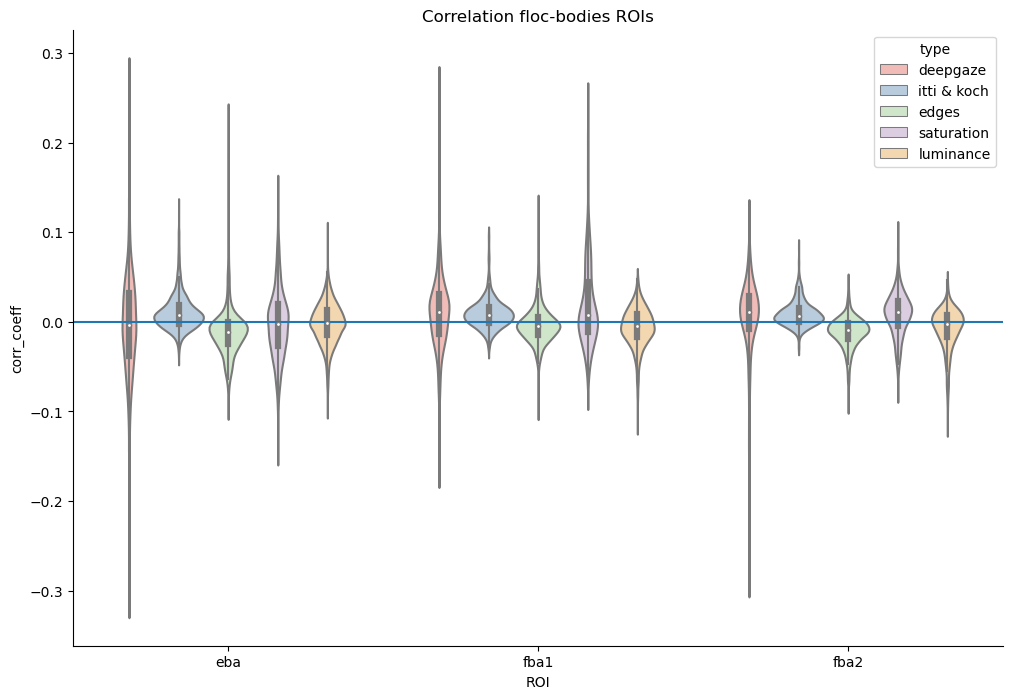

In [188]:
plt.figure(figsize=(12, 8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_words, corr_df_words_itti, corr_df_words_edges, corr_df_words_saturation, corr_df_words_luminance],
                  type_list = ["deepgaze","itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation floc-bodies ROIs")

### Dorsal ROIs (list A and B) 

In [189]:
corr_df_listA_itti = generate_corr_full(list_a, ittikoch_maps, print_log = False)

Computing correlation for v3a

Computing correlation for v3b

Computing correlation for ips0

Computing correlation for ips1

Computing correlation for ips2

Computing correlation for ips3

Computing correlation for ips4

Computing correlation for ips5

Computing correlation for spl1

Computing correlation for fef



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

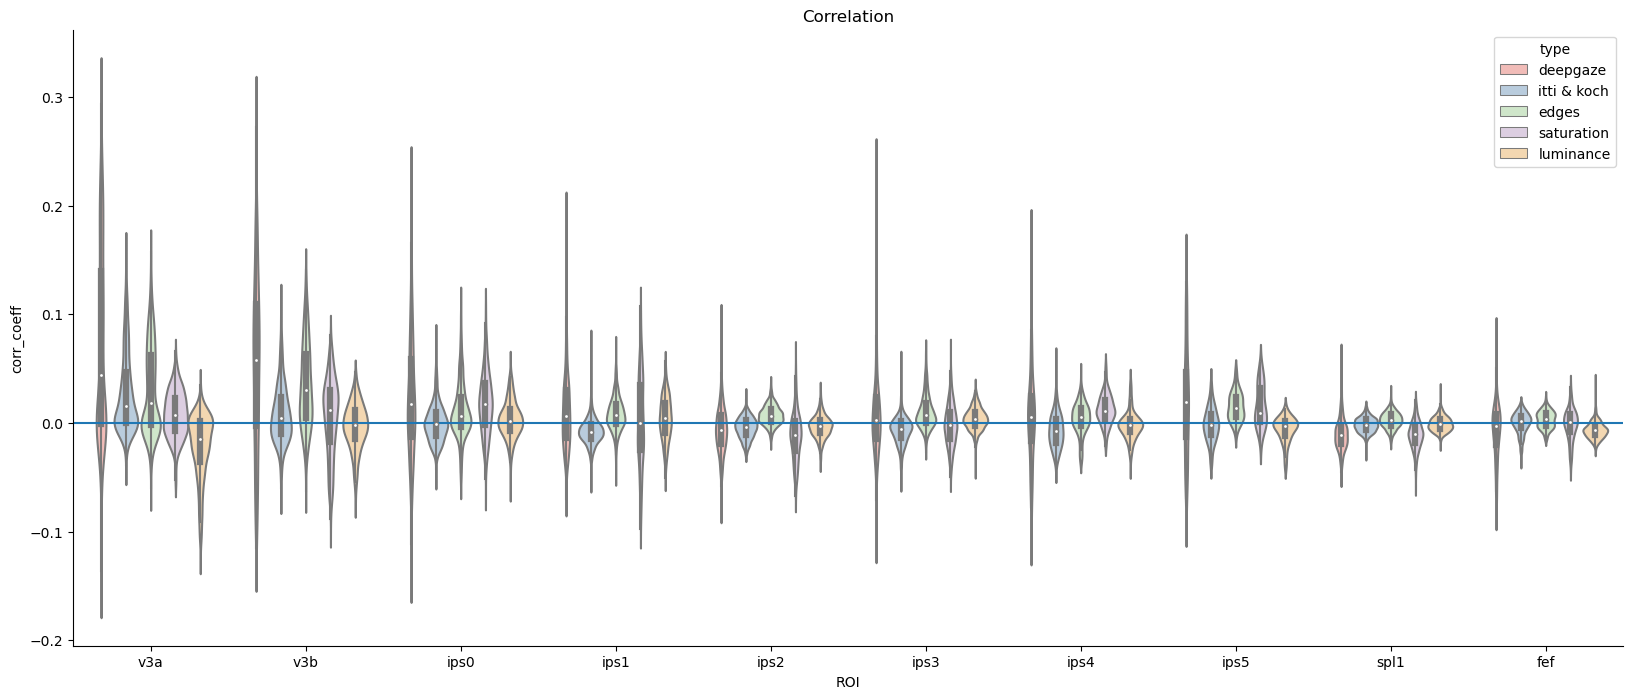

In [190]:
plt.figure(figsize=(20,8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_list_a, corr_df_listA_itti, corr_df_listA_edges, corr_df_listA_saturation, corr_df_listA_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation")

In [191]:
corr_df_listB_itti = generate_corr_full(list_b, ittikoch_maps, print_log = False)

Computing correlation for vo1

Computing correlation for vo2

Computing correlation for lo1

Computing correlation for lo2

Computing correlation for phc1

Computing correlation for phc2



/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_main = df_main.append(df_copy)
/tmp/ipykernel_22872/537000494.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

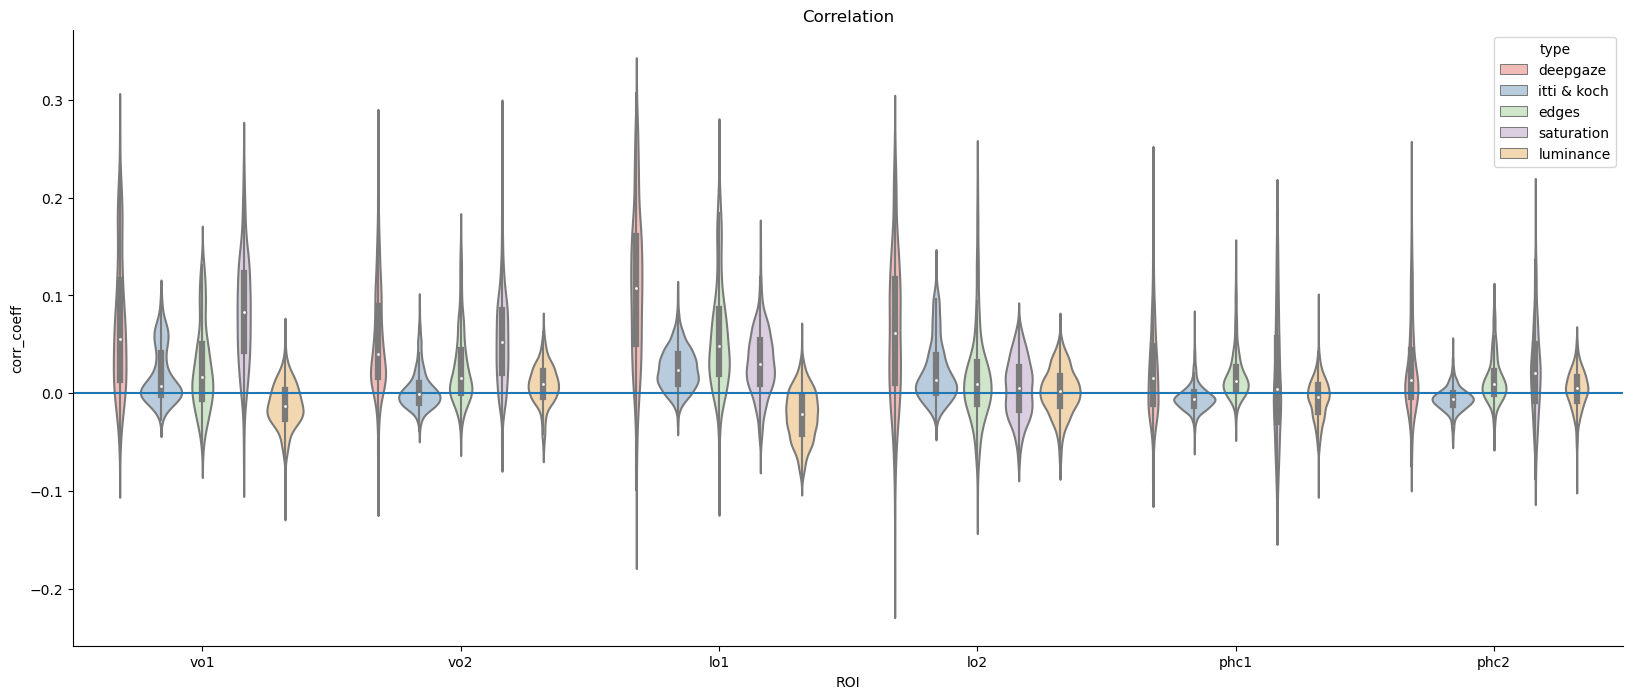

In [192]:
plt.figure(figsize=(20,8))

plot_corr_violinplot(df = concat_df_with_type(
                    df_list = [corr_df_list_b, corr_df_listB_itti, corr_df_listB_edges, corr_df_listB_saturation, corr_df_listB_luminance],
                  type_list = ["deepgaze", "itti & koch", "edges", "saturation", "luminance"]) ,                   
                      title = "Correlation")

# Weighted saliency maps 

According to probability instead of normal saliency

Generate correlations for scaled saliency maps according to the saliency score


In [93]:
sal_scores_df = pd.read_pickle(DATA_PATH+"/saliency_scores_df.pkl")
img_indices = pd.read_pickle(DATA_PATH+"/img_indices.pkl")

In [96]:
sal_scores_df.head()

probability
46002     0.910842
61882     0.939861
828       0.949775
67573     0.912687
16020     0.812731

In [97]:
def gen_scaled_saliency(sal_matrix, prob_scores):
    '''
    Generate a scaled saliency matrix (S) where the saliency maps are 
    scaled with their corresponding saliency scores 
    
    Args:
        sal_matrix: S matrix (unscaled)
        prob_scores: pandas df containing the saliency scores
    '''
    
    S_mat_scaled = S_mat.copy() 
    
    for idx in tqdm(range(sal_matrix.shape[0])):
        img_idx = img_indices[idx ]
        # get probablity score from the df or convert it to dict 
        prob_score = sal_scores_df.loc[img_idx, 'probability']
        
        S_mat_scaled[idx] = sal_matrix[idx] * prob_score
        
    return S_mat_scaled
        

In [98]:
S_mat_scaled = gen_scaled_saliency(S_mat, sal_scores_df)

100%|██████████| 27750/27750 [00:18<00:00, 1461.88it/s]


In [99]:
corr_df_viz_scaled = generate_corr_full(roi_list = viz_roi_list, S_mat = S_mat_scaled)

Computing correlation for v1

K matrix: (4165, 180625)
Betas matrix before valid: (27751, 7887)
Valid indices shape: (4165,)
Betas matrix: (27750, 4165)
Y_hat matrix: (27750, 4165)


Computing correlation for v2

K matrix: (4388, 180625)
Betas matrix before valid: (27751, 8296)
Valid indices shape: (4388,)
Betas matrix: (27750, 4388)
Y_hat matrix: (27750, 4388)


Computing correlation for v3

K matrix: (3311, 180625)
Betas matrix before valid: (27751, 7022)
Valid indices shape: (3311,)
Betas matrix: (27750, 3311)
Y_hat matrix: (27750, 3311)


Computing correlation for v4

K matrix: (2615, 180625)
Betas matrix before valid: (27751, 3976)
Valid indices shape: (2615,)
Betas matrix: (27750, 2615)
Y_hat matrix: (27750, 2615)




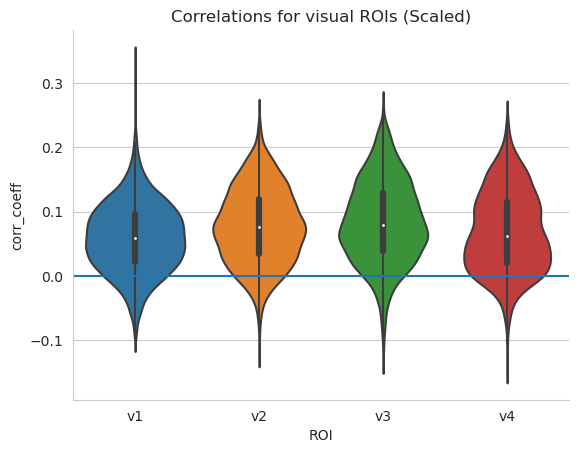

In [102]:
g = sns.violinplot(data = corr_df_viz_scaled, x = "ROI" , y = "corr_coeff")
sns.despine()
g.axhline(0)
g.set(title = 'Correlations for visual ROIs (Scaled)');

# Itti and Koch Saliency maps (low level) 

In [2]:
import pysaliency

In [14]:
dataset_location = 'datasets'
model_location = '/gpfs01/bartels/user/hbhatnagar/pysaliency_DL/models'

In [4]:
mit_stimuli, _ = pysaliency.external_datasets.get_mit1003(location=dataset_location)

In [5]:
aim = pysaliency.AIM(location=model_location)
saliency_map = aim.saliency_map(mit_stimuli.stimuli[0])

MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2018 The MathWorks, Inc.
                   R2018b (9.5.0.944444) 64-bit (glnxa64)
                              August 28, 2018

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
Reading Image.
Loading Basis.
Projecting local neighbourhoods into basis space.
0        25       50       75        100
........................................
Performing Density Estimation.
0        25       50       75        100
.......................................
Transforming likelihoods into information measures.


In [7]:
model_location = 'models'

In [16]:
itti = pysaliency.IttiKoch(location = model_location ,
                           saliency_toolbox_archive='/gpfs01/bartels/user/hbhatnagar/pysaliency_DL/saliency_toolbox.zip')

Extracting Saliency Toolbox
Applying enable_unit16
Patching centerSurround.m
Patching guiSaliency.m
Patching initializeImage.m
Patching loadImage.m


In [17]:
saliency_map = itti.saliency_map(mit_stimuli.stimuli[0])

MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2018 The MathWorks, Inc.
                   R2018b (9.5.0.944444) 64-bit (glnxa64)
                              August 28, 2018

 
To get started, type doc.
For product information, visit www.mathworks.com.
 

Saliency Toolbox (http://www.saliencytoolbox.net)
For licensing details type 'STBlicense' at the prompt.



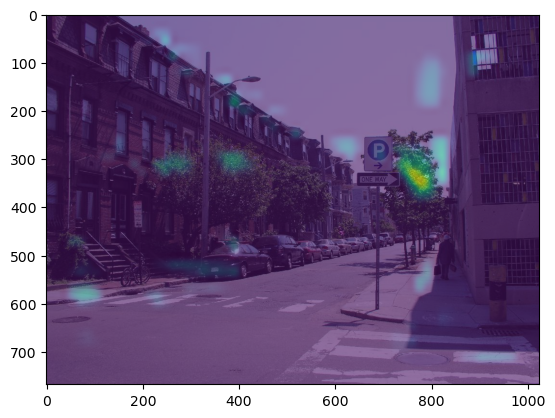

In [25]:
plt.imshow(saliency_map)
plt.imshow(mit_stimuli.stimuli[0], alpha = 0.4)

(-0.5, 1023.5, 767.5, -0.5)

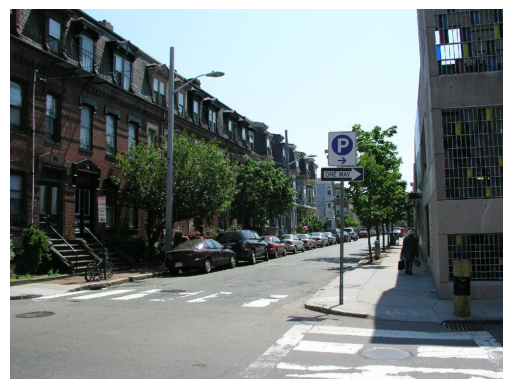

In [21]:
plt.imshow(mit_stimuli.stimuli[0])
plt.axis('off')